In [ ]:
"""
Weather Data Exploratory Data Analysis (EDA)
============================================

This notebook performs exploratory data analysis on weather variables,
focusing on time series decomposition, trend analysis, and seasonal patterns.

Variables analyzed:
- d2m: 2-meter dewpoint temperature
- u: U-component of wind
- v: V-component of wind
- msl: Mean sea level pressure
- r: Relative humidity
"""

# Standard library imports
import os
import sys
from datetime import datetime
import warnings

# Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

# Time series analysis
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

# Data processing
from sklearn.preprocessing import StandardScaler

# Wind visualization
from windrose import WindroseAxes

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [5]:
def setup_environment():
    """
    Set up the project environment by navigating to the project root directory
    and configuring necessary paths.
    
    Returns:
        str: The current working directory
    """
    try:
        # Navigate to project root directory
        os.chdir("../")
    except Exception as e:
        print(f"Error changing directory: {e}")
    
    # Get and display current working directory
    current_directory = os.getcwd()
    print(f"Working directory: {current_directory}")
    
    # Add notebooks directory to path for imports
    notebooks_path = os.path.abspath(os.path.join(current_directory, "notebooks"))
    if notebooks_path not in sys.path:
        sys.path.append(notebooks_path)
        print(f"Added to path: {notebooks_path}")
    
    return current_directory

def set_plot_style(size=14):
    """
    Set consistent plotting style parameters
    
    Args:
        size: Base font size
    """
    plt.rcParams.update({
        'font.size': size,
        'axes.titlesize': size + 2,
        'axes.labelsize': size,
        'xtick.labelsize': size - 2,
        'ytick.labelsize': size - 2,
        'legend.fontsize': size - 2,
        'figure.figsize': (10, 6),
        'figure.dpi': 100,
    })
    
    # Apply style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=size/12)

# Set up environment
current_dir = setup_environment()

# Import project utilities
try:
    from utils.utils import load_json_config
    from utils.utils_data import read_netcdf, read_netcdf_raw
    from utils.utils_parsers import batch_data_parser, model_parser, feature_map_parser
    
except ImportError as e:
    print(f"Error importing modules: {e}")

# Set plot style
set_plot_style()


Working directory: /home/yuhan/Desktop/Master
Added to path: /home/yuhan/Desktop/Master/notebooks


In [6]:
def load_weather_data(variables, frequency, time_unit, method, preprocessing, year_range):
    """
    Load weather data based on specified parameters
    
    Args:
        variables: String identifying the variables (e.g., 'd2muvmslr')
        frequency: Temporal frequency
        time_unit: Time unit ('h' for hours, 'd' for days)
        method: Resampling method
        preprocessing: Preprocessing method
        year_range: Tuple of (start_year, end_year)
        
    Returns:
        Loaded weather data
    """
    # Construct file path
    file_path = f"data/processed/{variables}_{frequency}{time_unit}_{method}_{preprocessing}_{year_range[0]}{year_range[1]}.h5"
    print(f"Loading data from: {file_path}")
    
    # Load the data
    try:
        data = read_netcdf(file_path)
        print(f"Data loaded successfully. {len(data)} time points.")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def process_weather_data(data, grid_point=(17, 17)):
    """
    Process weather data to extract variables at a specific grid point
    and calculate derived variables
    
    Args:
        data: Weather data from read_netcdf
        grid_point: Tuple of (y, x) coordinates for the grid point
        
    Returns:
        DataFrame containing processed data
    """
    y, x = grid_point
    d2m, u, v, msl, r, date_times = [], [], [], [], [], []
    
    # Extract data for each time point
    for item in data:
        date_times.append(item[0])
        d2m.append(item[1][0][y][x])
        u.append(item[1][1][y][x])
        v.append(item[1][2][y][x])
        msl.append(item[1][3][y][x])
        r.append(item[1][4][y][x])
    
    # Convert to numpy arrays
    d2m = np.array(d2m)
    u = np.array(u)
    v = np.array(v)
    msl = np.array(msl)
    r = np.array(r)
    
    # Convert timestamps to pandas datetime
    date_times = pd.to_datetime(date_times)
    
    # Calculate derived variables (wind speed and direction)
    wind_speed = np.sqrt(u**2 + v**2)
    wind_direction = (np.arctan2(v, u) * (180 / np.pi) - 90) % 360
    
    # Create DataFrame with all variables
    df = pd.DataFrame(
        {
            "d2m": d2m,           # 2-meter dewpoint temperature
            "u": u,               # U-component of wind
            "v": v,               # V-component of wind
            "msl": msl,           # Mean sea level pressure
            "r": r,               # Relative humidity
            "windspeed": wind_speed,  # Derived wind speed
            "direction": wind_direction,  # Derived wind direction
            "datetime": date_times,
        },
        index=date_times
    )
    
    # Add time-based features
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day"] = df.index.day
    df["hour"] = df.index.hour
    df["dayofyear"] = df.index.dayofyear
    
    return df

# Define data parameters
variables = "d2muvmslr"
variable_list = ["d2m", "u", "v", "msl", "r"]
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Load and process the weather data
all_variables_data = load_weather_data(
    variables=variables,
    frequency=selected_frequency,
    time_unit=time_unit,
    method=resample_method,
    preprocessing=preprocessing_method,
    year_range=year_range
)

# Process the weather data into a pandas DataFrame
df = process_weather_data(all_variables_data)

# Create resampled versions for different time scales
df_monthly = df.resample("ME").mean()  # Monthly averages
df_annual = df.resample("YE").mean()   # Annual averages

# Display dataset information
print("\nDataset summary:")
print(f"Time range: {df.index.min()} to {df.index.max()}")
print(f"Total time points: {len(df)}")
print(f"Years covered: {df.index.year.min()} to {df.index.year.max()}")
print("\nSample of data:")
print(df.head())

# Display basic statistics
print("\nBasic statistics:")
print(df[variable_list].describe())

Loading data from: data/processed/d2muvmslr_1h_none_raw_20042020.h5
Data loaded successfully. 146736 time points.
Data loaded successfully. 146736 time points.

Dataset summary:
Time range: 2004-04-06 00:00:00 to 2020-12-31 23:00:00
Total time points: 146736
Years covered: 2004 to 2020

Sample of data:
                            d2m          u          v            msl  \
2004-04-06 00:00:00  274.818172  11.733071 -14.363482  101010.838882   
2004-04-06 01:00:00  274.642188  11.786947 -13.703199  101008.408896   
2004-04-06 02:00:00  274.544054  11.651684 -13.387742  101009.292527   
2004-04-06 03:00:00  274.596136  11.660855 -13.052705  100985.765848   
2004-04-06 04:00:00  274.505678  11.735364 -13.003755  100977.923621   

                             r  windspeed   direction            datetime  \
2004-04-06 00:00:00  51.420153  18.546552  219.244293 2004-04-06 00:00:00   
2004-04-06 01:00:00  54.221952  18.075115  220.700810 2004-04-06 01:00:00   
2004-04-06 02:00:00  57.857972  

## Wind Analysis

Analyzing wind patterns through visualizing wind direction and speed distributions.

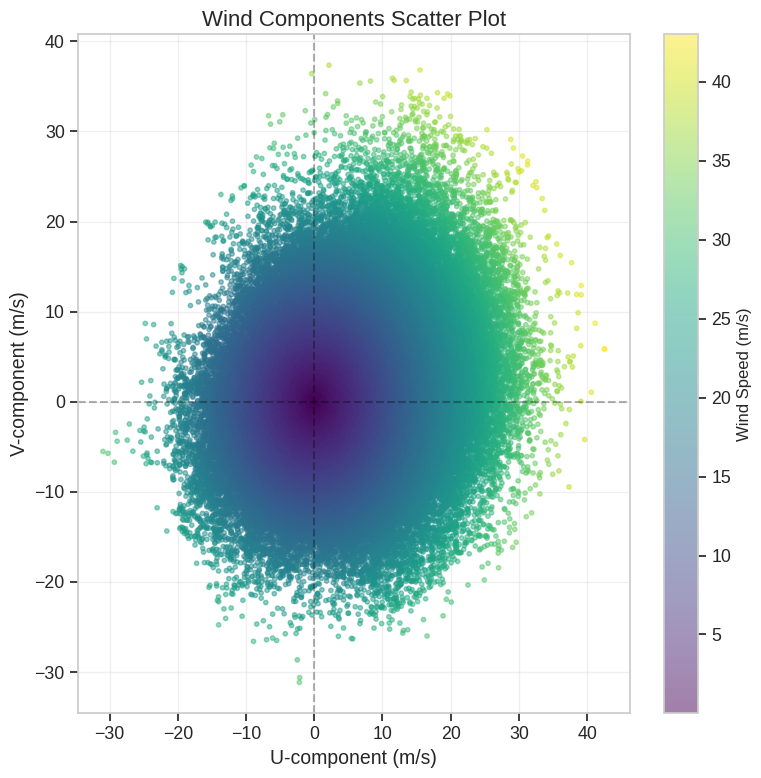

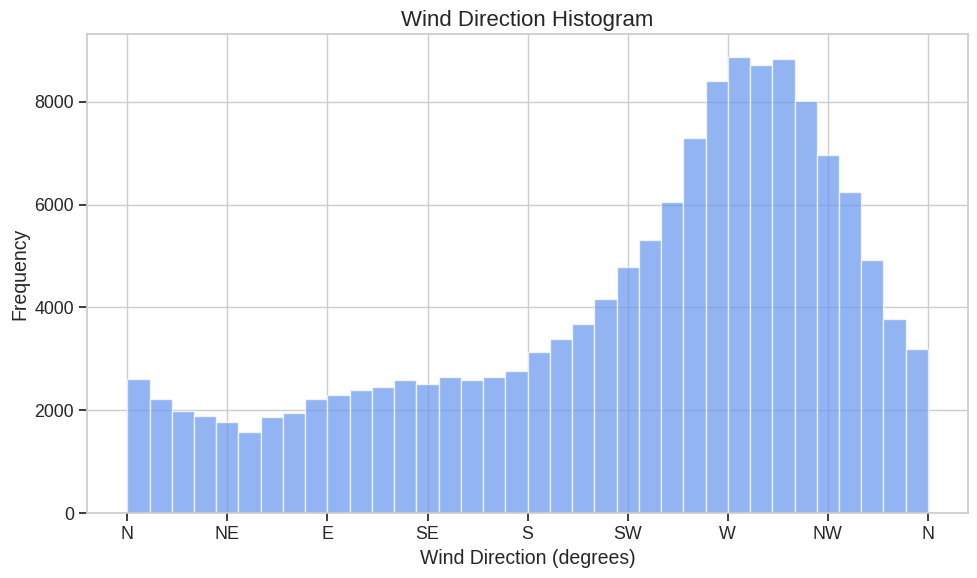

In [7]:
def plot_wind_components(data=None):
    """
    Create a scatter plot of wind components (u and v) colored by wind speed
    
    Args:
        data: DataFrame containing wind data (defaults to global df)
        
    Returns:
        Tuple of figure and axes objects
    """
    if data is None:
        data = df
        
    fig, ax = plt.subplots(figsize=(8, 8))
    
    scatter = ax.scatter(
        data['u'], 
        data['v'], 
        c=data['windspeed'], 
        cmap='viridis', 
        alpha=0.5, 
        s=10
    )
    
    ax.set_xlabel('U-component (m/s)', fontsize=14)
    ax.set_ylabel('V-component (m/s)', fontsize=14)
    ax.set_title('Wind Components Scatter Plot', fontsize=16)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.grid(True, linestyle='-', alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Wind Speed (m/s)', fontsize=12)
    
    plt.tight_layout()
    return fig, ax

def plot_wind_direction_histogram(data=None, bin_width=10):
    """
    Create a histogram of wind directions
    
    Args:
        data: DataFrame containing wind data (defaults to global df)
        bin_width: Width of histogram bins in degrees
        
    Returns:
        Tuple of figure and axes objects
    """
    if data is None:
        data = df
        
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create histogram with specific bins
    bins = np.arange(0, 361, bin_width)
    ax.hist(
        data['direction'], 
        bins=bins, 
        alpha=0.7, 
        color='cornflowerblue',
        edgecolor='white'
    )
    
    ax.set_xlabel('Wind Direction (degrees)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Wind Direction Histogram', fontsize=16)
    
    # Add cardinal direction labels
    cardinal_dirs = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    cardinal_angles = np.linspace(0, 360, len(cardinal_dirs))
    ax.set_xticks(cardinal_angles)
    ax.set_xticklabels(cardinal_dirs)
    
    plt.tight_layout()
    return fig, ax

# Plot wind components and direction
wind_comp_fig, wind_comp_ax = plot_wind_components()
wind_dir_fig, wind_dir_ax = plot_wind_direction_histogram()

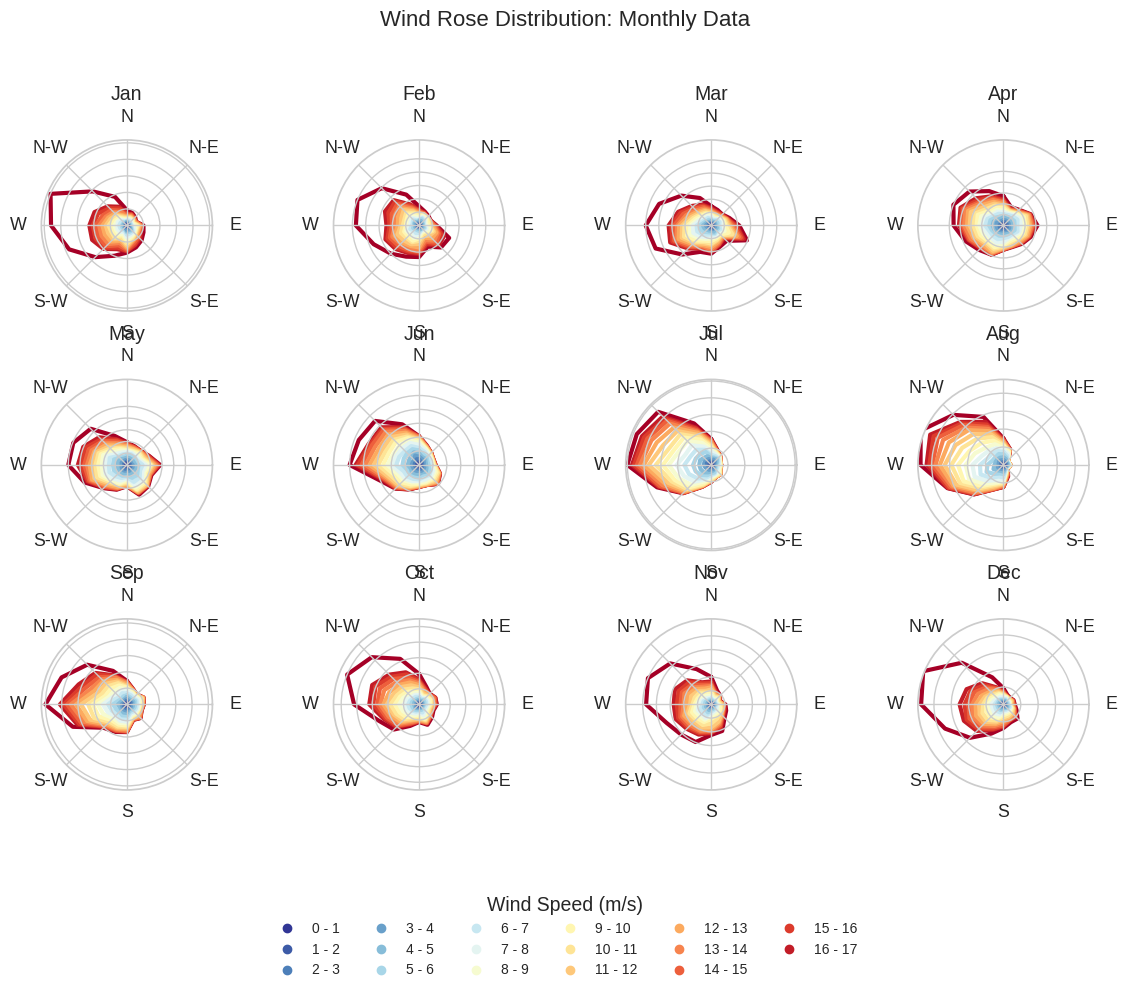

In [8]:
def plot_wind_rose(data=None, month_by_month=True, wind_speed_bins=None, max_radius=16):
    """
    Create wind rose plots to visualize wind speed and direction
    
    Args:
        data: DataFrame containing wind data (defaults to global df)
        month_by_month: If True, create monthly wind roses
        wind_speed_bins: Bins for wind speed (if None, use default bins)
        max_radius: Maximum radius for the wind rose
    
    Returns:
        Figure object
    """
    if data is None:
        data = df
        
    if wind_speed_bins is None:
        wind_speed_bins = np.arange(0.0, 18, 1)
    
    if month_by_month:
        # Monthly wind roses
        nrows, ncols = 3, 4
        fig = plt.figure(figsize=(14, 10), facecolor="white")
        fig.suptitle("Wind Rose Distribution: Monthly Data", fontsize=16)
        months_abbr = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        
        # Plot wind roses for each month
        for month in range(1, 13):
            ax = fig.add_subplot(nrows, ncols, month, projection="windrose")
            ax.set_title(f"{months_abbr[month-1]}", fontsize=14)
            
            # Filter data for current month
            df_month = data[data["month"] == month]
            
            if len(df_month) > 0:
                direction = df_month["direction"].values
                wind_speed = df_month["windspeed"].values
                
                # Create wind rose plot
                ax.contour(
                    direction, 
                    wind_speed, 
                    normed=True, 
                    bins=wind_speed_bins, 
                    cmap=cm.RdYlBu_r, 
                    lw=3
                )
                ax.set_rmax(max_radius)
            else:
                ax.text(0.5, 0.5, "No Data", 
                       horizontalalignment='center',
                       verticalalignment='center',
                       transform=ax.transAxes)
            
            # Hide y-axis labels for cleaner look
            ax.yaxis.set_tick_params(labelcolor='none')
        
        # Create legend manually
        colors = [cm.RdYlBu_r(i / (len(wind_speed_bins) - 1)) for i in range(len(wind_speed_bins) - 1)]
        labels = [f"{wind_speed_bins[i]:.0f} - {wind_speed_bins[i+1]:.0f}" for i in range(len(wind_speed_bins) - 1)]
        handles = [plt.Line2D([0], [0], color=color, marker="o", linestyle="") 
                  for color in colors]
        
        fig.legend(
            handles, 
            labels, 
            loc="lower center", 
            bbox_to_anchor=(0.5, 0), 
            ncol=6, 
            fontsize=10, 
            frameon=False,
            title="Wind Speed (m/s)"
        )
        
        # Adjust layout
        plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2, hspace=0.4, wspace=0.2)
    
    else:
        # Single wind rose for all data
        fig = plt.figure(figsize=(10, 10), facecolor="white")
        ax = fig.add_subplot(111, projection="windrose")
        
        # Create wind rose
        ax.contour(
            data["direction"].values, 
            data["windspeed"].values,
            normed=True, 
            bins=wind_speed_bins, 
            cmap=cm.RdYlBu_r
        )
        
        ax.set_title("Wind Rose Distribution (All Data)", fontsize=16)
    
    return fig

# Plot monthly wind roses
wind_rose_fig = plot_wind_rose(month_by_month=True)

## Time Series Decomposition

Decomposing time series into trend, seasonal, and residual components using STL (Seasonal and Trend decomposition using Loess).

### Monthly Decomposition

Analyzing monthly patterns in weather variables using STL decomposition.

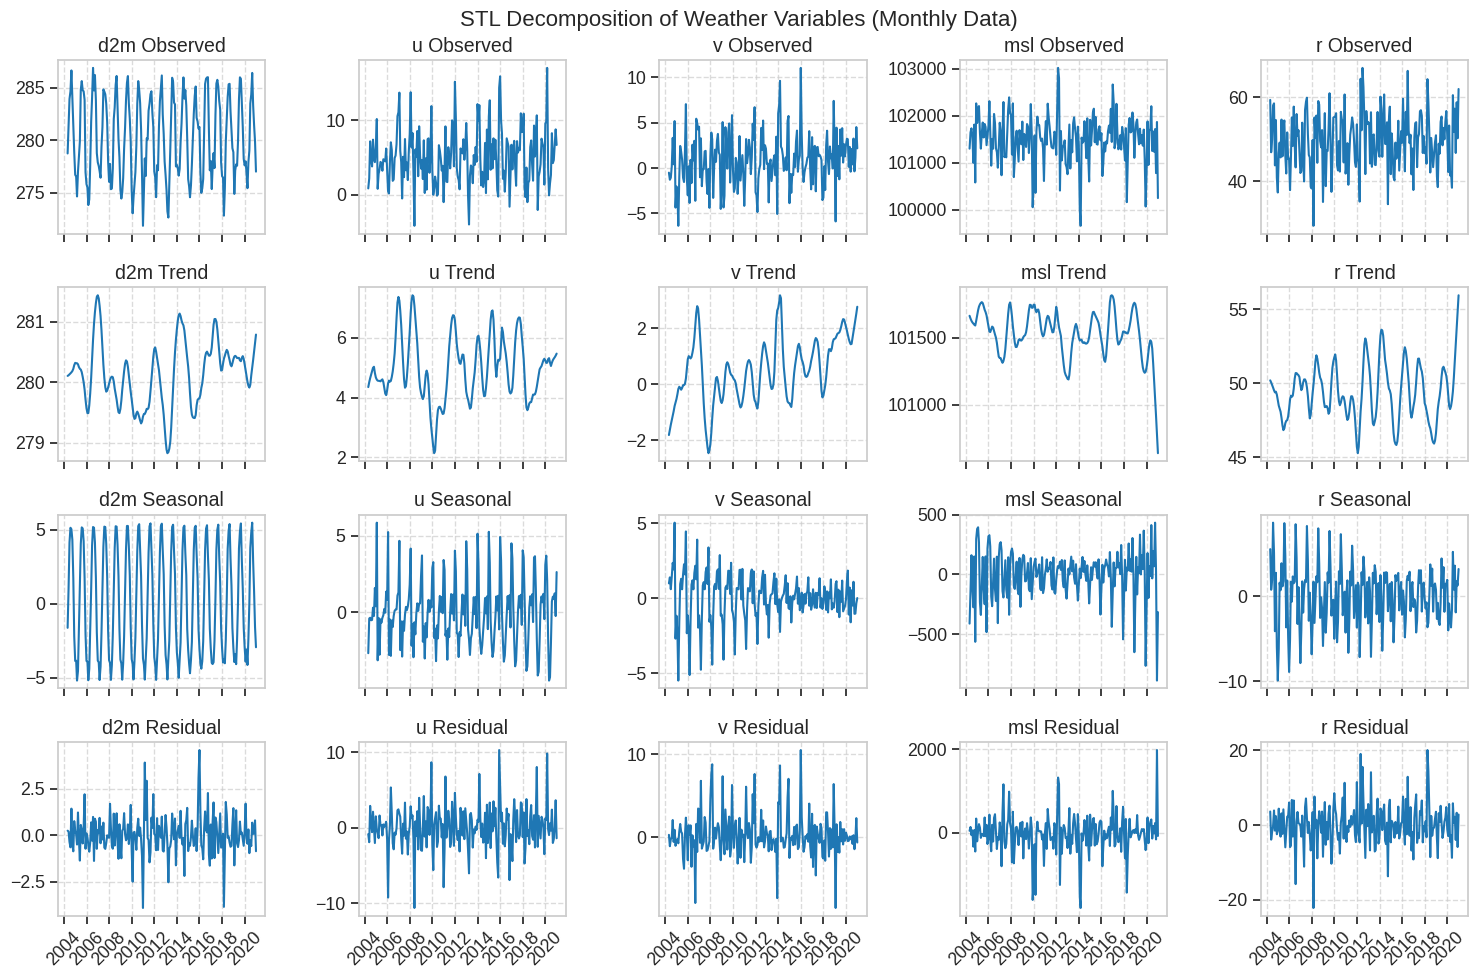

In [9]:
def perform_stl_decomposition(data, variable, period, seasonal=None, trend=None, robust=True):
    """
    Perform STL decomposition on time series data
    
    Args:
        data: DataFrame containing time series data
        variable: Variable name to decompose
        period: Number of observations per seasonal cycle
        seasonal: Length of the seasonal smoother
        trend: Length of the trend smoother
        robust: Flag indicating whether to use robust fitting
        
    Returns:
        Result of STL decomposition
    """
    # If seasonal or trend not provided, set defaults based on period
    if seasonal is None:
        seasonal = period + 1
    if trend is None:
        trend = seasonal  # trend must be odd and >= period
    
    # Ensure trend is odd
    if trend % 2 == 0:
        trend += 1
    
    # Create STL model
    stl_model = STL(
        data[variable],
        seasonal=seasonal,
        period=period,
        robust=robust,
        trend=trend
    )
    
    # Fit the model
    result = stl_model.fit()
    
    return result

def plot_stl_decomposition(results, variable_names, data, title_suffix=""):
    """
    Plot STL decomposition components for multiple variables
    
    Args:
        results: List of STL decomposition results
        variable_names: List of variable names
        data: Original data
        title_suffix: Additional text for the title
        
    Returns:
        Figure object
    """
    n_vars = len(variable_names)
    fig, axes = plt.subplots(4, n_vars, figsize=(3*n_vars, 10), sharex='col')
    
    # Components to plot
    components = ['observed', 'trend', 'seasonal', 'resid']
    component_titles = ['Observed', 'Trend', 'Seasonal', 'Residual']
    
    for i, var_name in enumerate(variable_names):
        res = results[i]
        
        # Plot each component
        for j, (component, title) in enumerate(zip(components, component_titles)):
            component_data = getattr(res, component)
            axes[j, i].plot(component_data, linewidth=1.5)
            axes[j, i].set_title(f'{var_name} {title}')
            
            # Add grid
            axes[j, i].grid(True, linestyle='--', alpha=0.7)
            
            # Format x-axis except for the bottom row
            if j < 3:
                axes[j, i].tick_params(labelbottom=False)
            else:
                axes[j, i].tick_params(axis='x', rotation=45)
    
    # Add main title
    fig.suptitle(f'STL Decomposition of Weather Variables {title_suffix}', 
                fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    return fig

# Perform monthly STL decomposition
monthly_results = []
for var in variable_list:
    monthly_result = perform_stl_decomposition(
        data=df_monthly,
        variable=var,
        period=12,  # 12 months per year
        seasonal=13,
        trend=13,
        robust=True
    )
    monthly_results.append(monthly_result)

# Plot monthly decomposition
monthly_fig = plot_stl_decomposition(
    results=monthly_results,
    variable_names=variable_list,
    data=df_monthly,
    title_suffix="(Monthly Data)"
)

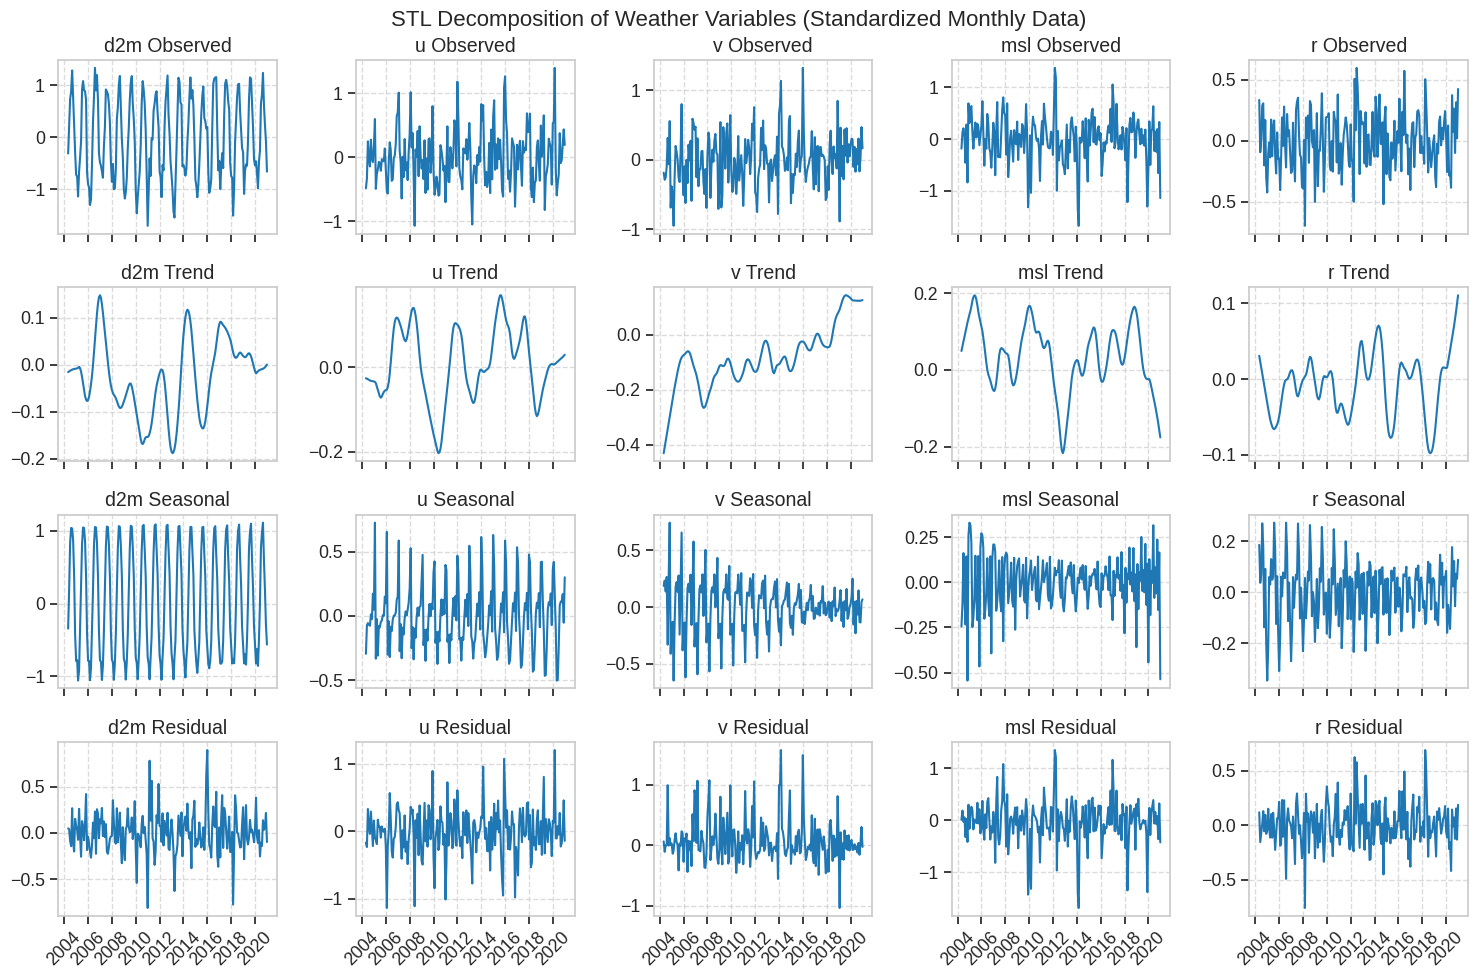

In [10]:
def standardize_data(data, columns):
    """
    Standardize variables to have mean=0 and std=1
    
    Args:
        data: DataFrame containing data to standardize
        columns: List of column names to standardize
        
    Returns:
        DataFrame with standardized values
    """
    scaler = StandardScaler()
    standardized_data = data.copy()
    standardized_data[columns] = scaler.fit_transform(data[columns])
    return standardized_data

# Create standardized versions of the data
standardized_df = standardize_data(df, variable_list)
standardized_df_monthly = standardized_df.resample("ME").mean()

# Perform STL decomposition on standardized data
standardized_monthly_results = []
for var in variable_list:
    result = perform_stl_decomposition(
        data=standardized_df_monthly,
        variable=var,
        period=12,
        seasonal=13,
        trend=23,
        robust=True
    )
    standardized_monthly_results.append(result)

# Plot decomposition of standardized data
standardized_monthly_fig = plot_stl_decomposition(
    results=standardized_monthly_results,
    variable_names=variable_list,
    data=standardized_df_monthly,
    title_suffix="(Standardized Monthly Data)"
)

## Hourly Time Series Analysis

Analyzing sub-daily patterns in weather variables to identify diurnal cycles and short-term fluctuations.

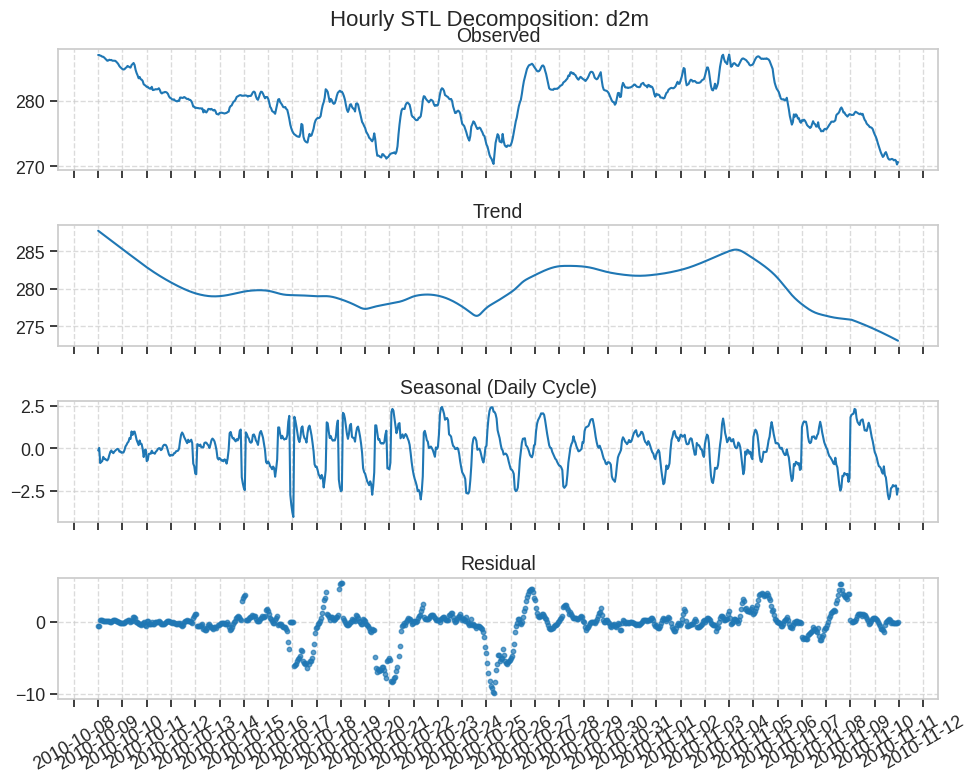

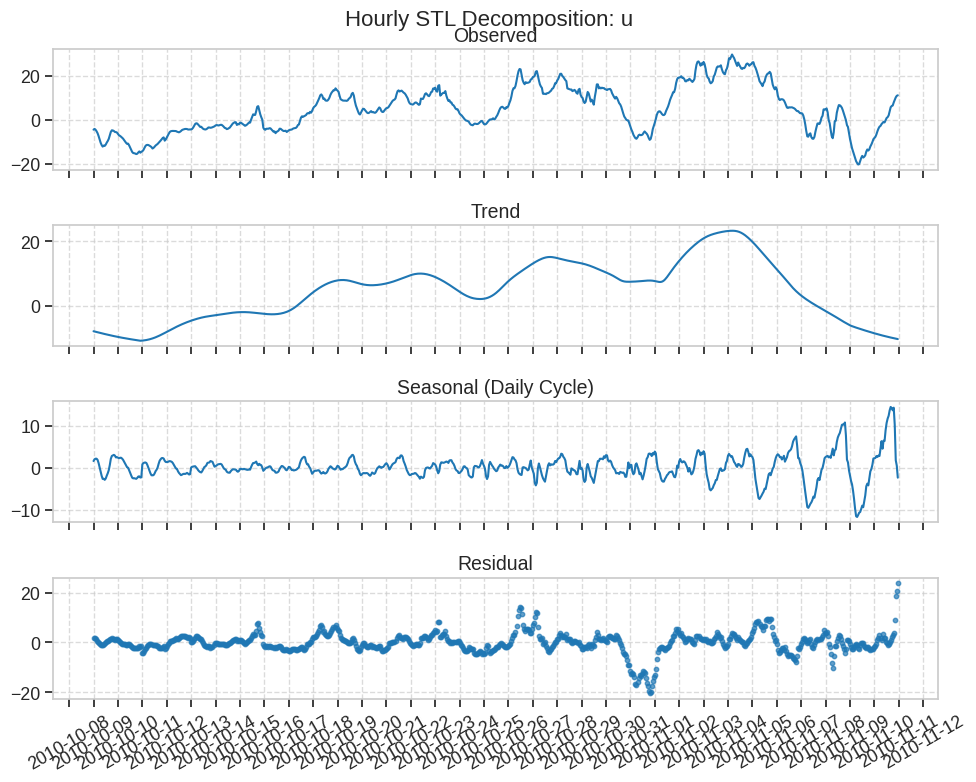

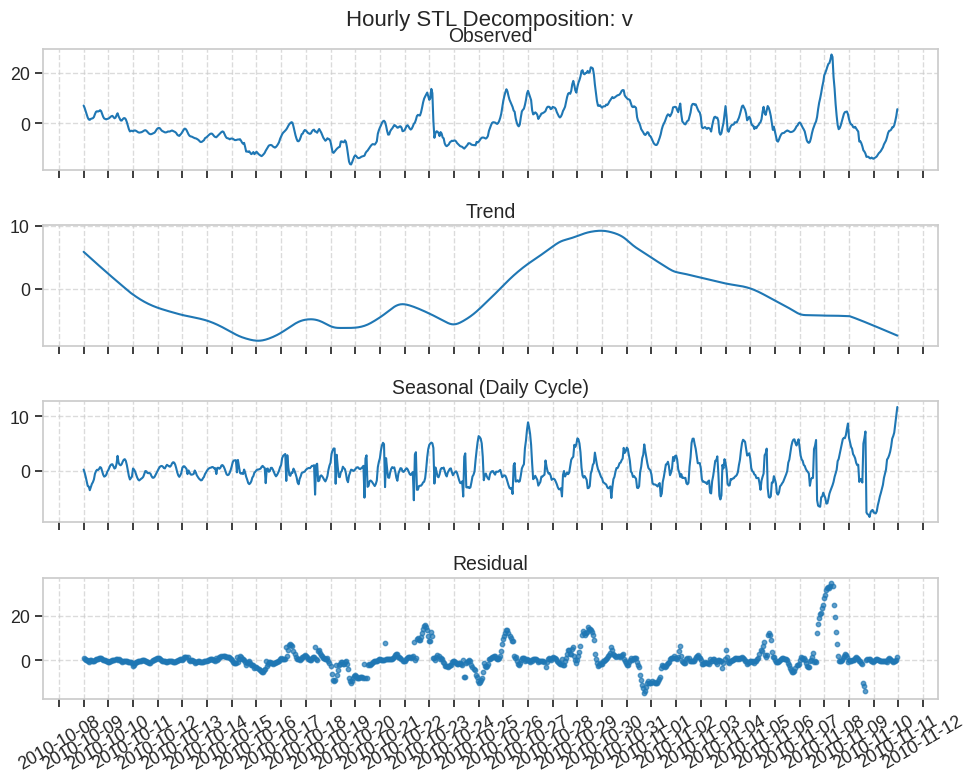

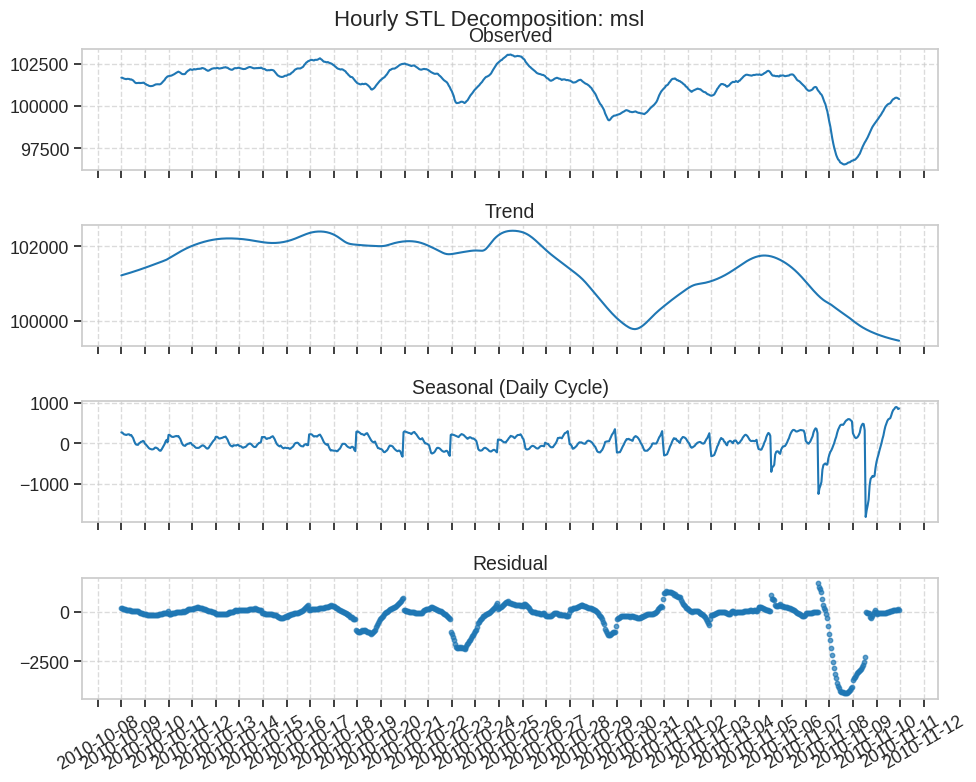

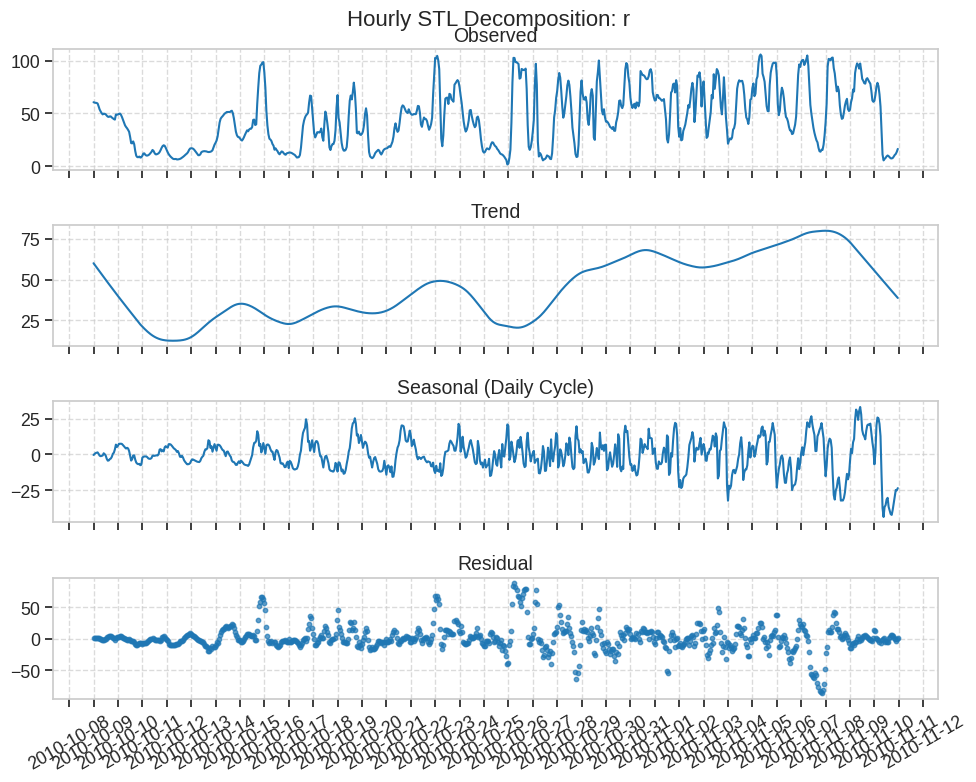

In [11]:
def plot_hourly_decomposition(data, variable, start_date, end_date, period=24):
    """
    Plot STL decomposition for hourly data with a focus on daily patterns
    
    Args:
        data: DataFrame containing time series data
        variable: Variable name to decompose
        start_date: Start date for the sample
        end_date: End date for the sample
        period: Number of observations per seasonal cycle (24 for daily cycle in hourly data)
        
    Returns:
        Figure object
    """
    # Extract sample data
    sample_data = data[start_date:end_date][variable]
    
    # Perform STL decomposition
    stl = STL(sample_data, period=period, robust=True)
    result = stl.fit()
    
    # Create figure
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    
    # Components to plot
    components = [result.observed, result.trend, result.seasonal, result.resid]
    titles = ['Observed', 'Trend', 'Seasonal (Daily Cycle)', 'Residual']
    
    # Plot each component
    for i, (component, title) in enumerate(zip(components, titles)):
        if i < 3:  # Line plots for observed, trend, and seasonal
            axes[i].plot(component, linewidth=1.5)
        else:  # Scatter plot for residuals
            axes[i].scatter(component.index, component, s=10, alpha=0.7)
        
        axes[i].set_title(f'{title}')
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Format x-axis
        axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].tick_params(axis='x', rotation=30)
    
    # Add variable name as main title
    fig.suptitle(f'Hourly STL Decomposition: {variable}', fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    return fig

# Define sample period for hourly analysis
start_date = '2010-10-09'
end_date = '2010-11-10'

# Plot hourly decomposition for each variable
hourly_decomposition_figs = []
for i, var in enumerate(variable_list):
    hourly_fig = plot_hourly_decomposition(
        data=df,
        variable=var,
        start_date=start_date,
        end_date=end_date,
        period=48  # For 48-hour cycle (2-day pattern)
    )
    
    hourly_decomposition_figs.append(hourly_fig)
    plt.show()

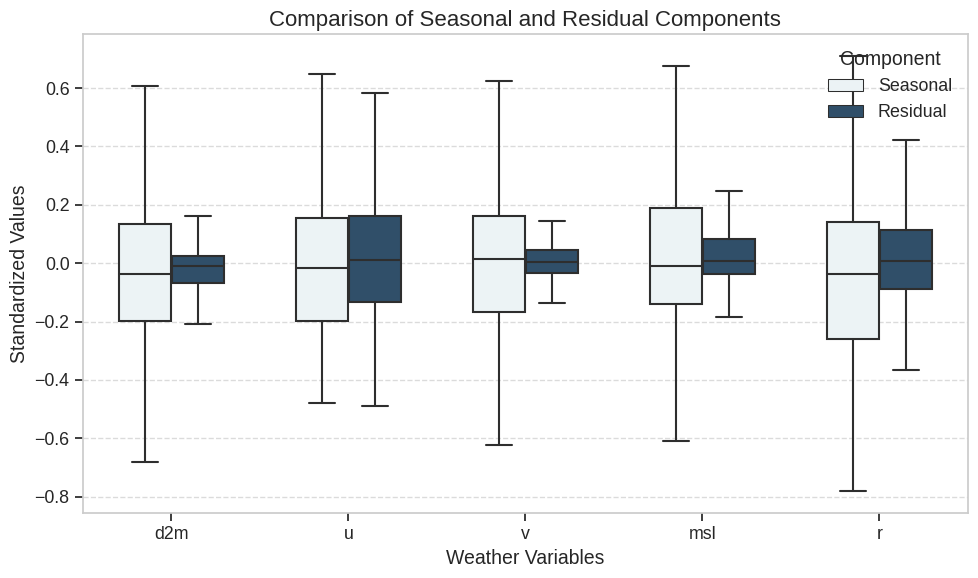

In [12]:
def compare_seasonal_residual_components(data, start_date, end_date, period=48):
    """
    Compare seasonal and residual components across variables using boxplots
    
    Args:
        data: DataFrame containing time series data
        start_date: Start date for the sample
        end_date: End date for the sample
        period: Number of observations per seasonal cycle
        
    Returns:
        Figure object and decomposition results
    """
    # Extract sample data
    sample_data = data[start_date:end_date]
    
    # Store decomposition results
    seasonal_data = pd.DataFrame()
    residual_data = pd.DataFrame()
    
    # Perform STL decomposition for each variable
    for var in variable_list:
        # Extract variable data
        hourly_data = sample_data[var]
        
        # Perform decomposition
        stl_model = STL(
            hourly_data,
            period=period,  # 48-hour period (2-day pattern)
            robust=True
        )
        result = stl_model.fit()
        
        # Store components
        seasonal_data[var] = result.seasonal
        residual_data[var] = result.resid
    
    # Label components
    seasonal_data['Type'] = 'Seasonal'
    residual_data['Type'] = 'Residual'
    
    # Combine data for plotting
    combined_data = pd.concat([seasonal_data, residual_data])
    
    # Melt data for seaborn
    melted_data = combined_data.melt(id_vars='Type', var_name='Variable', value_name='Value')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create boxplot
    colors = {'Seasonal': '#EBF4F6', 'Residual': '#265073'}
    box = sns.boxplot(
        x='Variable', 
        y='Value', 
        hue='Type', 
        data=melted_data, 
        palette=colors, 
        ax=ax, 
        width=0.6, 
        dodge=True, 
        showfliers=False
    )
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Component")
    
    # Set title and labels
    ax.set_title('Comparison of Seasonal and Residual Components', fontsize=16)
    ax.set_xlabel('Weather Variables', fontsize=14)
    ax.set_ylabel('Standardized Values', fontsize=14)
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, (seasonal_data, residual_data)

# Compare seasonal and residual components
start_date = '2010-10-09'
end_date = '2010-10-20'
comparison_fig, component_data = compare_seasonal_residual_components(
    data=standardized_df,  # Use standardized data for better comparison
    start_date=start_date,
    end_date=end_date,
    period=48
)


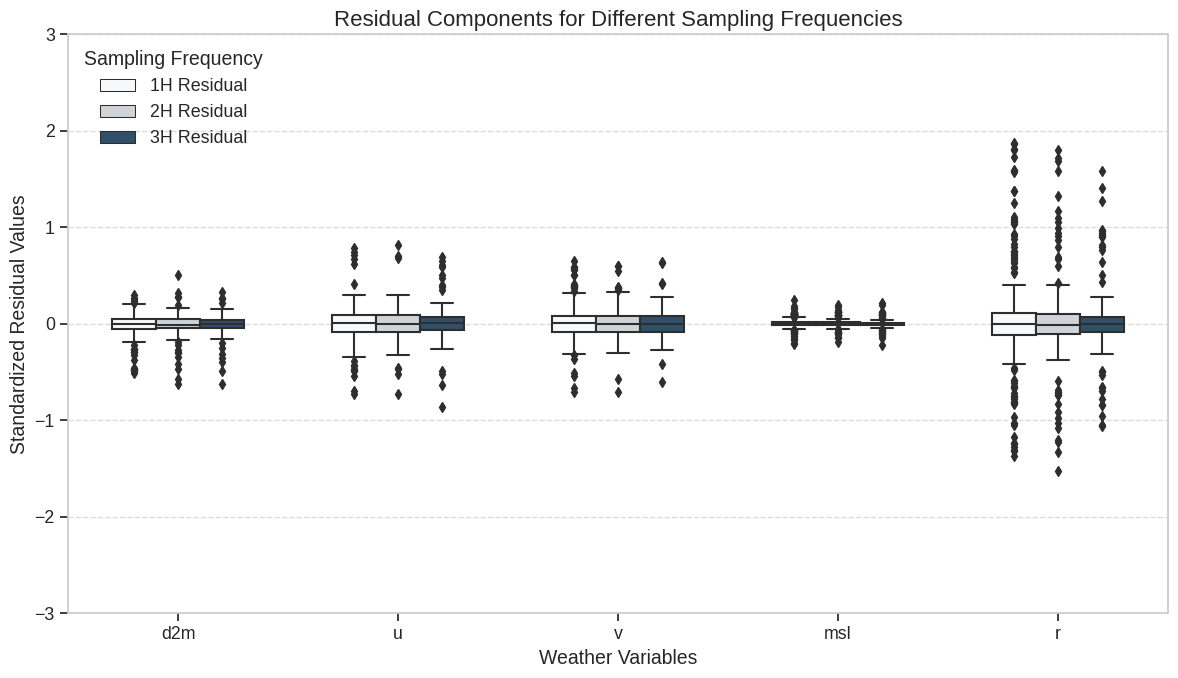

In [13]:
def compare_different_sampling_frequencies(start_date, end_date, frequencies=None):
    """
    Compare STL decomposition residuals for different sampling frequencies
    
    Args:
        start_date: Start date for the sample
        end_date: End date for the sample
        frequencies: List of sampling frequencies in hours
        
    Returns:
        Figure object
    """
    if frequencies is None:
        frequencies = [1, 2, 3]
        
    # Create resampled dataframes for each frequency
    resampled_dfs = {}
    standardized_dfs = {}
    residual_dfs = {}
    
    # Original 1-hour data is already available as df
    resampled_dfs[1] = df
    
    # Create resampled versions for other frequencies
    for freq in frequencies:
        if freq > 1:
            resampled_dfs[freq] = df.resample(f'{freq}H').first()
    
    # Standardize all datasets
    for freq, data in resampled_dfs.items():
        standardized_dfs[freq] = standardize_data(data, variable_list)
    
    # Extract samples for the specified date range
    sample_dfs = {}
    for freq, data in standardized_dfs.items():
        sample_dfs[freq] = data[start_date:end_date]
    
    # Perform STL decomposition and extract residuals
    for freq, data in sample_dfs.items():
        # Determine appropriate period and parameters based on frequency
        if freq == 1:
            period = 24
            seasonal = 25
            trend = 25
        elif freq == 2:
            period = 12
            seasonal = 13
            trend = 13
        elif freq == 3:
            period = 8
            seasonal = 9
            trend = 9
        else:
            # Default parameters for other frequencies
            period = max(24 // freq, 4)
            seasonal = period + 1
            trend = seasonal
        
        # Create empty DataFrame for residuals
        residual_df = pd.DataFrame()
        
        # Perform decomposition for each variable
        for var in variable_list:
            stl_model = STL(
                data[var],
                seasonal=seasonal,
                period=period,
                robust=True,
                trend=trend
            )
            result = stl_model.fit()
            residual_df[var] = result.resid
        
        # Add frequency label
        residual_df['Type'] = f'{freq}H Residual'
        
        # Store results
        residual_dfs[freq] = residual_df
    
    # Combine all residuals
    combined_residuals = pd.concat(residual_dfs.values())
    
    # Melt data for seaborn
    melted_residuals = combined_residuals.melt(
        id_vars='Type', 
        var_name='Variable', 
        value_name='Value'
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define colors
    if len(frequencies) == 3:
        colors = {
            '1H Residual': '#f8f9fa', 
            '2H Residual': '#ced4da', 
            '3H Residual': '#265073'
        }
    else:
        colors = None
    
    # Create boxplot
    sns.boxplot(
        x='Variable', 
        y='Value', 
        hue='Type', 
        data=melted_residuals, 
        palette=colors, 
        ax=ax, 
        width=0.6
    )
    
    # Set y-axis limits for better comparison
    ax.set_ylim(-3, 3)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Sampling Frequency")
    
    # Set title and labels
    ax.set_title('Residual Components for Different Sampling Frequencies', fontsize=16)
    ax.set_xlabel('Weather Variables', fontsize=14)
    ax.set_ylabel('Standardized Residual Values', fontsize=14)
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Compare different sampling frequencies
start_date = '2011-11-04'
end_date = '2011-11-19'
sampling_freq_fig = compare_different_sampling_frequencies(
    start_date=start_date, 
    end_date=end_date,
    frequencies=[1, 2, 3]
)

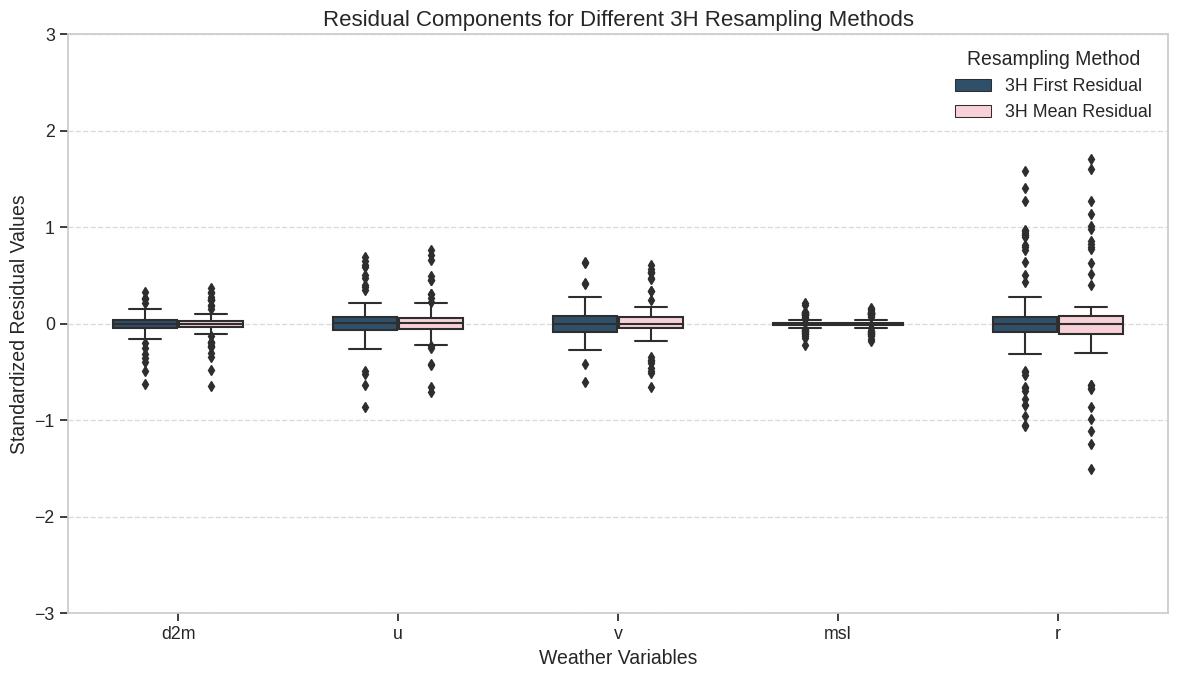

In [14]:
def compare_resampling_methods(start_date, end_date, frequency=3, methods=None):
    """
    Compare STL decomposition residuals for different resampling methods
    
    Args:
        start_date: Start date for the sample
        end_date: End date for the sample
        frequency: Sampling frequency in hours
        methods: List of resampling methods
        
    Returns:
        Figure object
    """
    if methods is None:
        methods = ['first', 'mean']
        
    # Create resampled dataframes for each method
    resampled_dfs = {}
    standardized_dfs = {}
    residual_dfs = {}
    
    # Resample data using different methods
    for method in methods:
        if method == 'first':
            resampled_dfs[method] = df.resample(f'{frequency}H').first()
        elif method == 'mean':
            resampled_dfs[method] = df.resample(f'{frequency}H').mean()
        elif method == 'max':
            resampled_dfs[method] = df.resample(f'{frequency}H').max()
        elif method == 'min':
            resampled_dfs[method] = df.resample(f'{frequency}H').min()
        else:
            # Default to first method
            resampled_dfs[method] = df.resample(f'{frequency}H').first()
    
    # Standardize all datasets
    for method, data in resampled_dfs.items():
        standardized_dfs[method] = standardize_data(data, variable_list)
    
    # Extract samples for the specified date range
    sample_dfs = {}
    for method, data in standardized_dfs.items():
        sample_dfs[method] = data[start_date:end_date]
    
    # Determine STL parameters based on frequency
    if frequency == 3:
        period = 8
        seasonal = 9
        trend = 9
    else:
        # Default parameters
        period = max(24 // frequency, 4)
        seasonal = period + 1
        trend = seasonal
    
    # Perform STL decomposition and extract residuals
    for method, data in sample_dfs.items():
        # Create empty DataFrame for residuals
        residual_df = pd.DataFrame()
        
        # Perform decomposition for each variable
        for var in variable_list:
            stl_model = STL(
                data[var],
                seasonal=seasonal,
                period=period,
                robust=True,
                trend=trend
            )
            result = stl_model.fit()
            residual_df[var] = result.resid
        
        # Add method label
        method_display = method.capitalize()
        residual_df['Type'] = f'{frequency}H {method_display} Residual'
        
        # Store results
        residual_dfs[method] = residual_df
    
    # Combine all residuals
    combined_residuals = pd.concat(residual_dfs.values())
    
    # Melt data for seaborn
    melted_residuals = combined_residuals.melt(
        id_vars='Type', 
        var_name='Variable', 
        value_name='Value'
    )
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Define colors for two methods
    if len(methods) == 2 and set(methods) == set(['first', 'mean']):
        colors = {
            f'{frequency}H First Residual': '#265073',
            f'{frequency}H Mean Residual': '#ffcad4'
        }
    else:
        colors = None
    
    # Create boxplot
    sns.boxplot(
        x='Variable', 
        y='Value', 
        hue='Type', 
        data=melted_residuals, 
        palette=colors, 
        ax=ax, 
        width=0.6
    )
    
    # Set y-axis limits for better comparison
    ax.set_ylim(-3, 3)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Resampling Method")
    
    # Set title and labels
    ax.set_title(f'Residual Components for Different {frequency}H Resampling Methods', fontsize=16)
    ax.set_xlabel('Weather Variables', fontsize=14)
    ax.set_ylabel('Standardized Residual Values', fontsize=14)
    
    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Compare different resampling methods for 3-hour data
start_date = '2011-11-04'
end_date = '2011-11-19'
resampling_methods_fig = compare_resampling_methods(
    start_date=start_date, 
    end_date=end_date,
    frequency=3,
    methods=['first', 'mean']
)


## Long-term Trends and Distribution Analysis

Analyzing long-term trends and distributions of weather variables across years and months.

TypeError: float() argument must be a string or a real number, not 'pandas._libs.interval.Interval'

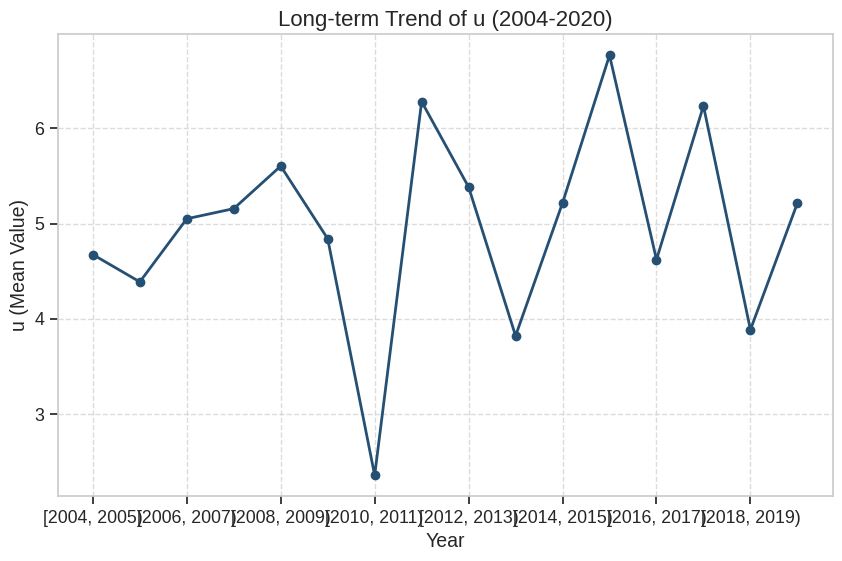

In [15]:
def analyze_long_term_trends(data_monthly, variable='u'):
    """
    Analyze and plot long-term trends for a weather variable
    
    Args:
        data_monthly: Monthly resampled DataFrame
        variable: Variable name to analyze
        
    Returns:
        Tuple of figures
    """
    # Create yearly bins for analysis
    start_year = data_monthly.index.year.min()
    end_year = data_monthly.index.year.max()
    year_bins = np.arange(start_year, end_year + 1, 1).tolist()
    
    # Add year bin column
    year_trends = data_monthly.copy()
    year_trends["year_bin"] = pd.cut(data_monthly.index.year, bins=year_bins, right=False)
    
    # Calculate yearly means
    year_trend = year_trends.groupby("year_bin").mean()[variable]
    
    # Plot yearly trend
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    year_trend.plot(
        ax=ax1,
        marker='o',
        markersize=6,
        linestyle='-',
        linewidth=2,
        color='#265073'
    )
    
    ax1.set_xlabel('Year', fontsize=14)
    ax1.set_ylabel(f'{variable} (Mean Value)', fontsize=14)
    ax1.set_title(f'Long-term Trend of {variable} ({start_year}-{end_year})', fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Fit a linear trend line
    years_numeric = np.arange(len(year_trend))
    z = np.polyfit(years_numeric, year_trend.values, 1)
    p = np.poly1d(z)
    
    ax1.plot(
        year_trend.index, 
        p(years_numeric), 
        "r--", 
        linewidth=1.5,
        label=f'Trend: {z[0]:.4f}x + {z[1]:.4f}'
    )
    ax1.legend()
    
    # Create boxplots by month and year
    fig2, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
    
    # Monthly distribution
    sns.boxplot(
        y=data_monthly[variable], 
        x=data_monthly.index.month, 
        whis=1.5, 
        ax=axes[0],
        palette='Blues'
    )
    axes[0].set_title(f'Monthly Distribution of {variable}', fontsize=14)
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].set_ylabel(variable, fontsize=12)
    axes[0].set_xticks(range(12))
    axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    # Yearly distribution
    sns.boxplot(
        y=data_monthly[variable], 
        x=data_monthly.index.year, 
        whis=1.5, 
        ax=axes[1],
        palette='Greens'
    )
    axes[1].set_title(f'Yearly Distribution of {variable}', fontsize=14)
    axes[1].set_xlabel('Year', fontsize=12)
    axes[1].set_ylabel(variable, fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Add a common title
    fig2.suptitle(f'Distribution Analysis of {variable}', fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig1, fig2

# Analyze long-term trends for different variables
trend_u_fig, dist_u_fig = analyze_long_term_trends(df_monthly, variable='u')
trend_msl_fig, dist_msl_fig = analyze_long_term_trends(df_monthly, variable='msl')

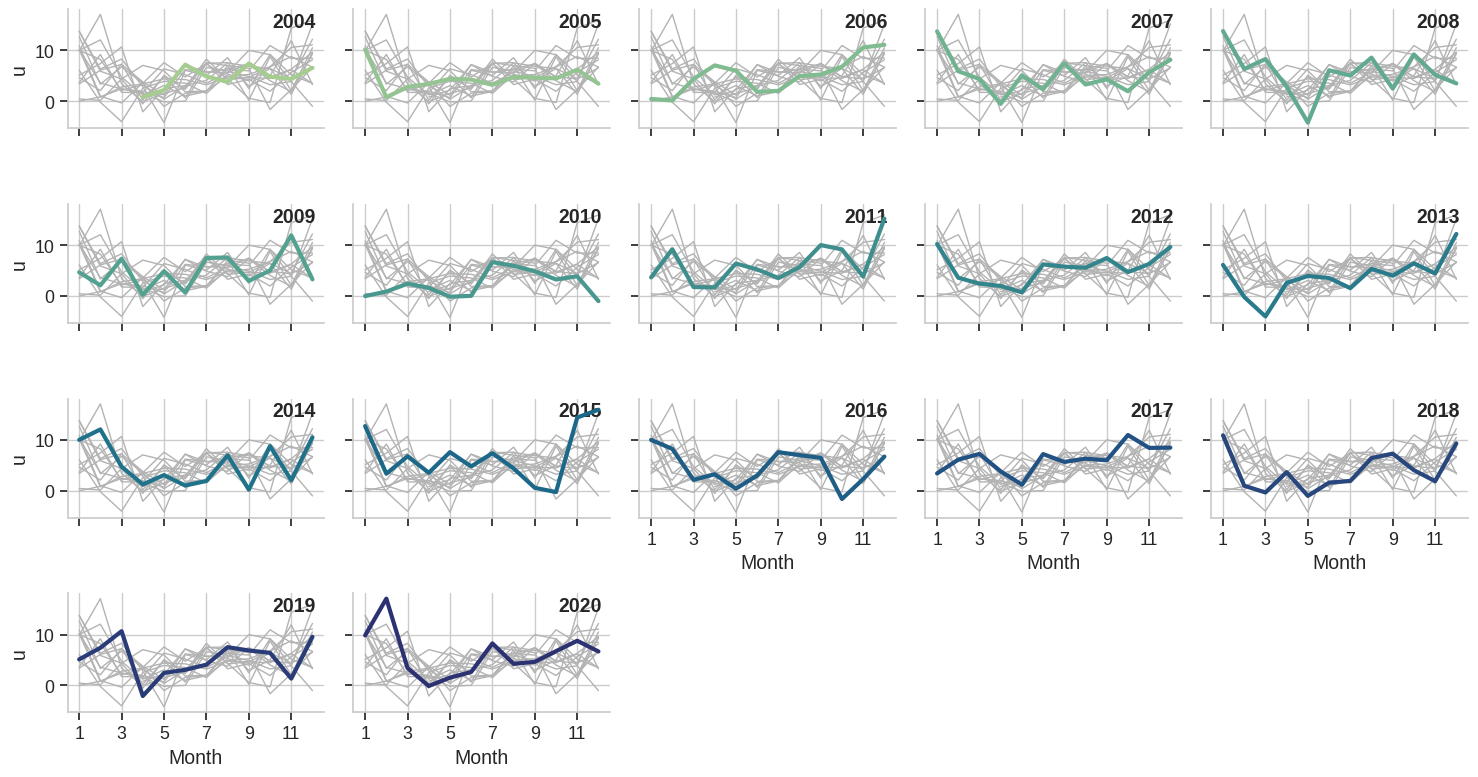

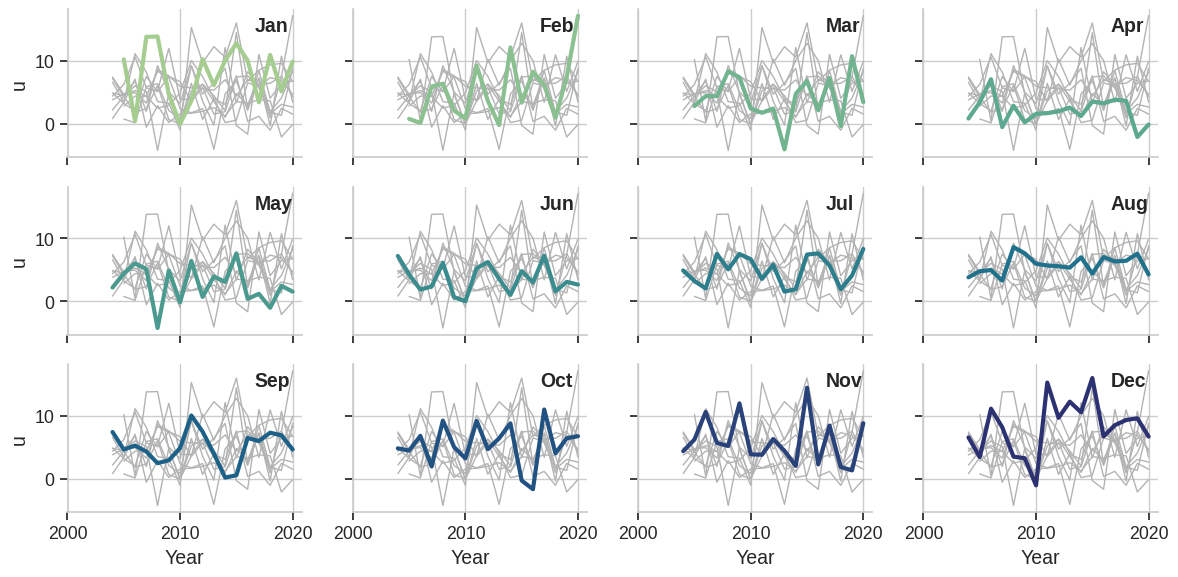

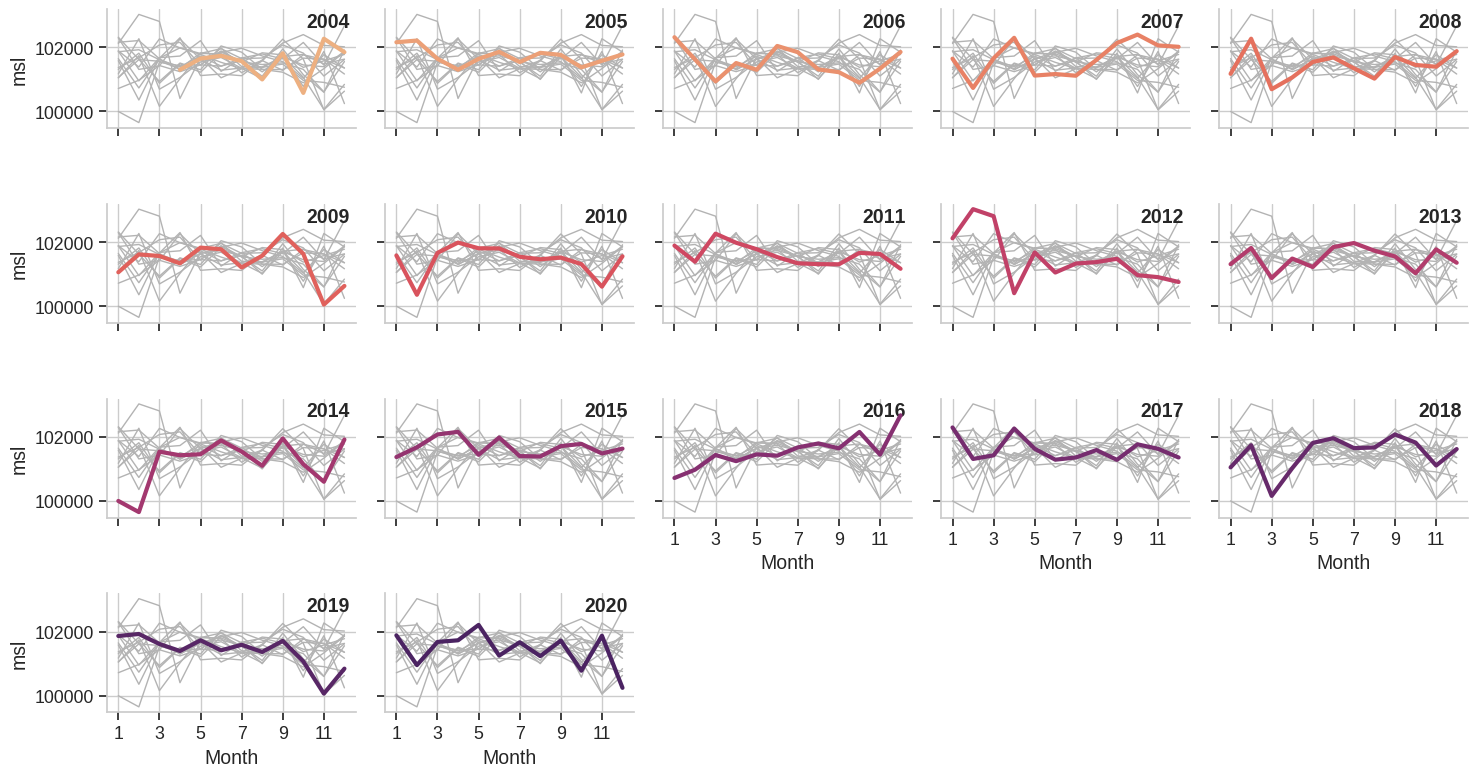

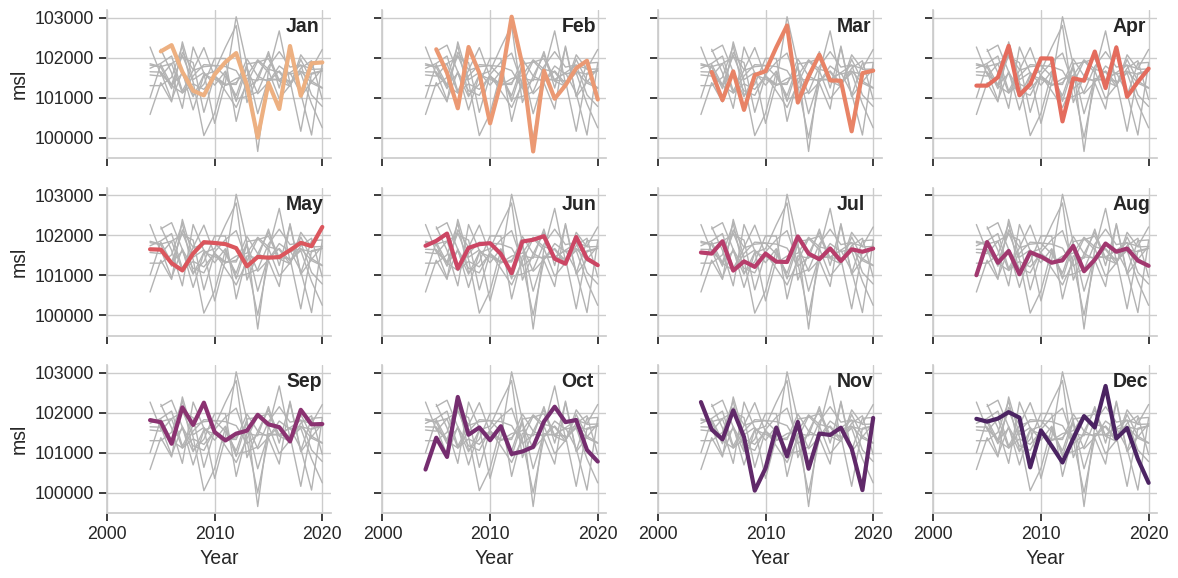

In [16]:
def analyze_multiyear_patterns(data_monthly, variable='u', palette='crest'):
    """
    Analyze and visualize monthly patterns across multiple years
    
    Args:
        data_monthly: Monthly resampled DataFrame
        variable: Variable name to analyze
        palette: Color palette for the plots
        
    Returns:
        Tuple of plot objects
    """
    # Create a relplot showing each year's time series
    g1 = sns.relplot(
        data=data_monthly,
        x=data_monthly.index.month,
        y=data_monthly[variable],
        col=data_monthly.index.year,
        hue=data_monthly.index.year,
        kind="line",
        palette=palette,
        linewidth=3,
        zorder=5,
        col_wrap=5,
        height=2,
        aspect=1.5,
        legend=False,
    )

    # Iterate over each subplot to customize further
    for year, ax in g1.axes_dict.items():
        # Add the title as an annotation within the plot
        ax.text(0.8, 0.85, year, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=data_monthly,
            x=data_monthly.index.month,
            y=data_monthly[variable],
            units=data_monthly.index.year,
            estimator=None,
            color=".7",
            linewidth=1,
            ax=ax,
        )
    
    # Reduce the frequency of the x axis ticks
    ax.set_xticks(range(1, 13, 2))
    
    # Tweak the supporting aspects of the plot
    g1.set_titles("")
    g1.set_axis_labels("Month", variable)
    g1.tight_layout()
    
    # Create a second relplot showing each month's time series across years
    g2 = sns.relplot(
        data=data_monthly,
        x=data_monthly.index.year,
        y=data_monthly[variable],
        col=data_monthly.index.month,
        hue=data_monthly.index.month,
        kind="line",
        palette=palette,
        linewidth=3,
        zorder=5,
        col_wrap=4,
        height=2,
        aspect=1.5,
        legend=False,
    )

    # Iterate over each subplot to customize further
    months_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for i, (month, ax) in enumerate(g2.axes_dict.items()):
        # Add the title as an annotation within the plot
        ax.text(0.8, 0.85, months_abbr[i], transform=ax.transAxes, fontweight="bold")

        # Plot every month's time series in the background
        sns.lineplot(
            data=data_monthly,
            x=data_monthly.index.year,
            y=data_monthly[variable],
            units=data_monthly.index.month,
            estimator=None,
            color=".7",
            linewidth=1,
            ax=ax,
        )
    
    # Reduce the frequency of the x axis ticks
    ax.set_xticks(ax.get_xticks()[::2])
    
    # Tweak the supporting aspects of the plot
    g2.set_titles("")
    g2.set_axis_labels("Year", variable)
    g2.tight_layout()
    
    return g1, g2

# Analyze multiyear patterns for different variables
g_u_year, g_u_month = analyze_multiyear_patterns(df_monthly, variable='u', palette='crest')
g_msl_year, g_msl_month = analyze_multiyear_patterns(df_monthly, variable='msl', palette='flare')

## Time Series Forecasting

Using STL-based forecasting to predict future weather patterns.

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  201
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -550.366
Date:                Sat, 21 Jun 2025   AIC                           1106.732
Time:                        04:02:23   BIC                           1116.627
Sample:                    04-30-2004   HQIC                          1110.736
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0116      0.195      0.060      0.953      -0.371       0.394
ar.L1         -0.4032      0.060     -6.737      0.000      -0.520      -0.286
sigma2        14.3663      1.087     13.218      0.0

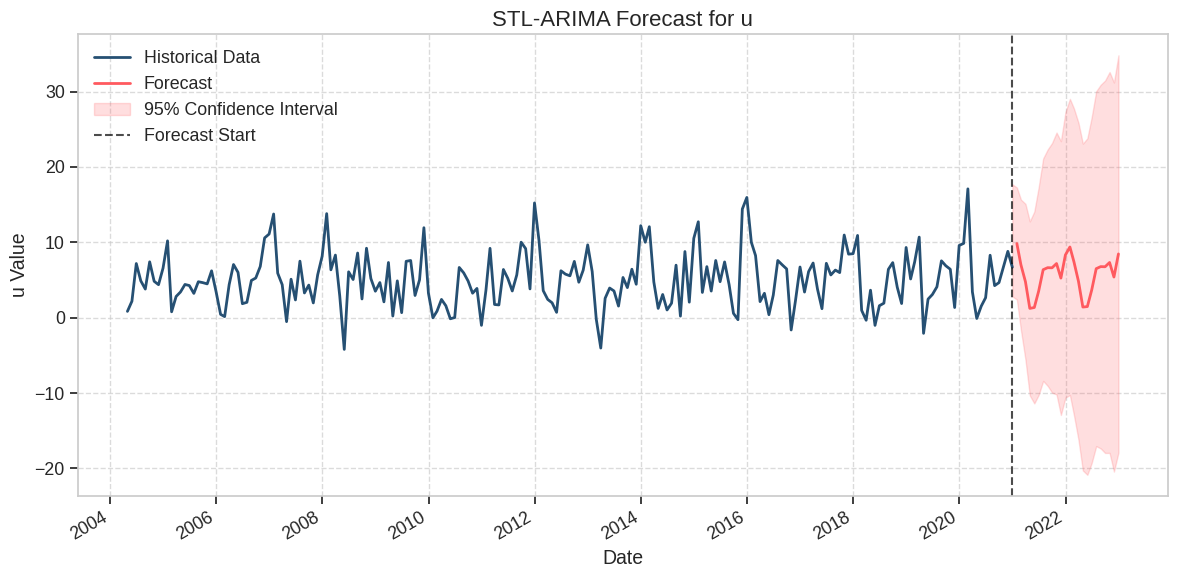

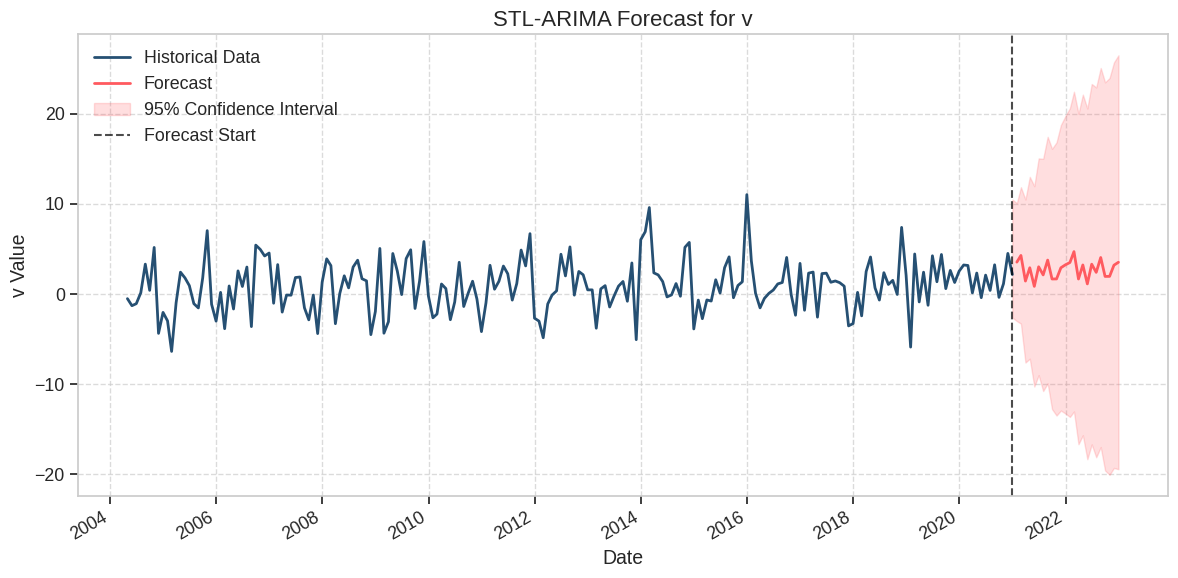

In [17]:
def forecast_with_stl_arima(data, variable, forecast_periods=50, order=(1, 1, 0)):
    """
    Perform forecasting using STL decomposition combined with ARIMA
    
    Args:
        data: DataFrame containing time series data
        variable: Variable name to forecast
        forecast_periods: Number of periods to forecast
        order: ARIMA order tuple (p, d, q)
        
    Returns:
        Tuple of forecast results and figure
    """
    # Ensure datetime index has frequency
    ts_data = data[variable].copy()
    if ts_data.index.freq is None:
        ts_data.index.freq = data.index.inferred_freq
    
    # Create STL-Forecast model
    stlf = STLForecast(
        ts_data,
        ARIMA,
        seasonal=13,
        period=12,
        robust=True,
        model_kwargs=dict(order=order, trend="t"),
    )
    
    # Fit the model
    stlf_result = stlf.fit()
    
    # Generate forecast
    forecast = stlf_result.forecast(forecast_periods)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot historical data
    ax.plot(
        ts_data.index, 
        ts_data.values, 
        label='Historical Data',
        color='#265073',
        linewidth=2
    )
    
    # Plot forecast
    ax.plot(
        forecast.index, 
        forecast.values, 
        label='Forecast',
        color='#FF5A5F',
        linewidth=2
    )
    
    # Add shading for forecast uncertainty (if available in the model)
    try:
        # Get forecast confidence intervals
        pred_int = stlf_result.get_prediction(
            start=ts_data.index[-1], 
            end=forecast.index[-1]
        ).conf_int(alpha=0.05)
        
        # Plot confidence intervals
        ax.fill_between(
            pred_int.index,
            pred_int.iloc[:, 0],
            pred_int.iloc[:, 1],
            color='#FF5A5F',
            alpha=0.2,
            label='95% Confidence Interval'
        )
    except:
        # Skip confidence intervals if not available
        pass
    
    # Add vertical line separating historical data from forecast
    ax.axvline(
        x=ts_data.index[-1], 
        color='black', 
        linestyle='--', 
        alpha=0.7,
        label='Forecast Start'
    )
    
    # Set title and labels
    ax.set_title(f'STL-ARIMA Forecast for {variable}', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(f'{variable} Value', fontsize=14)
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best')
    
    # Format x-axis dates
    fig.autofmt_xdate()
    
    # Adjust layout
    plt.tight_layout()
    
    return stlf_result, fig

# Perform forecasting for multiple wind variables
forecast_result_u, forecast_fig_u = forecast_with_stl_arima(
    data=df_monthly,
    variable='u',
    forecast_periods=24,  # Forecast for 2 years
    order=(1, 1, 0)
)

forecast_result_v, forecast_fig_v = forecast_with_stl_arima(
    data=df_monthly,
    variable='v',
    forecast_periods=24,
    order=(1, 1, 0)
)

# Print model summary for u-component
print(forecast_result_u.summary())

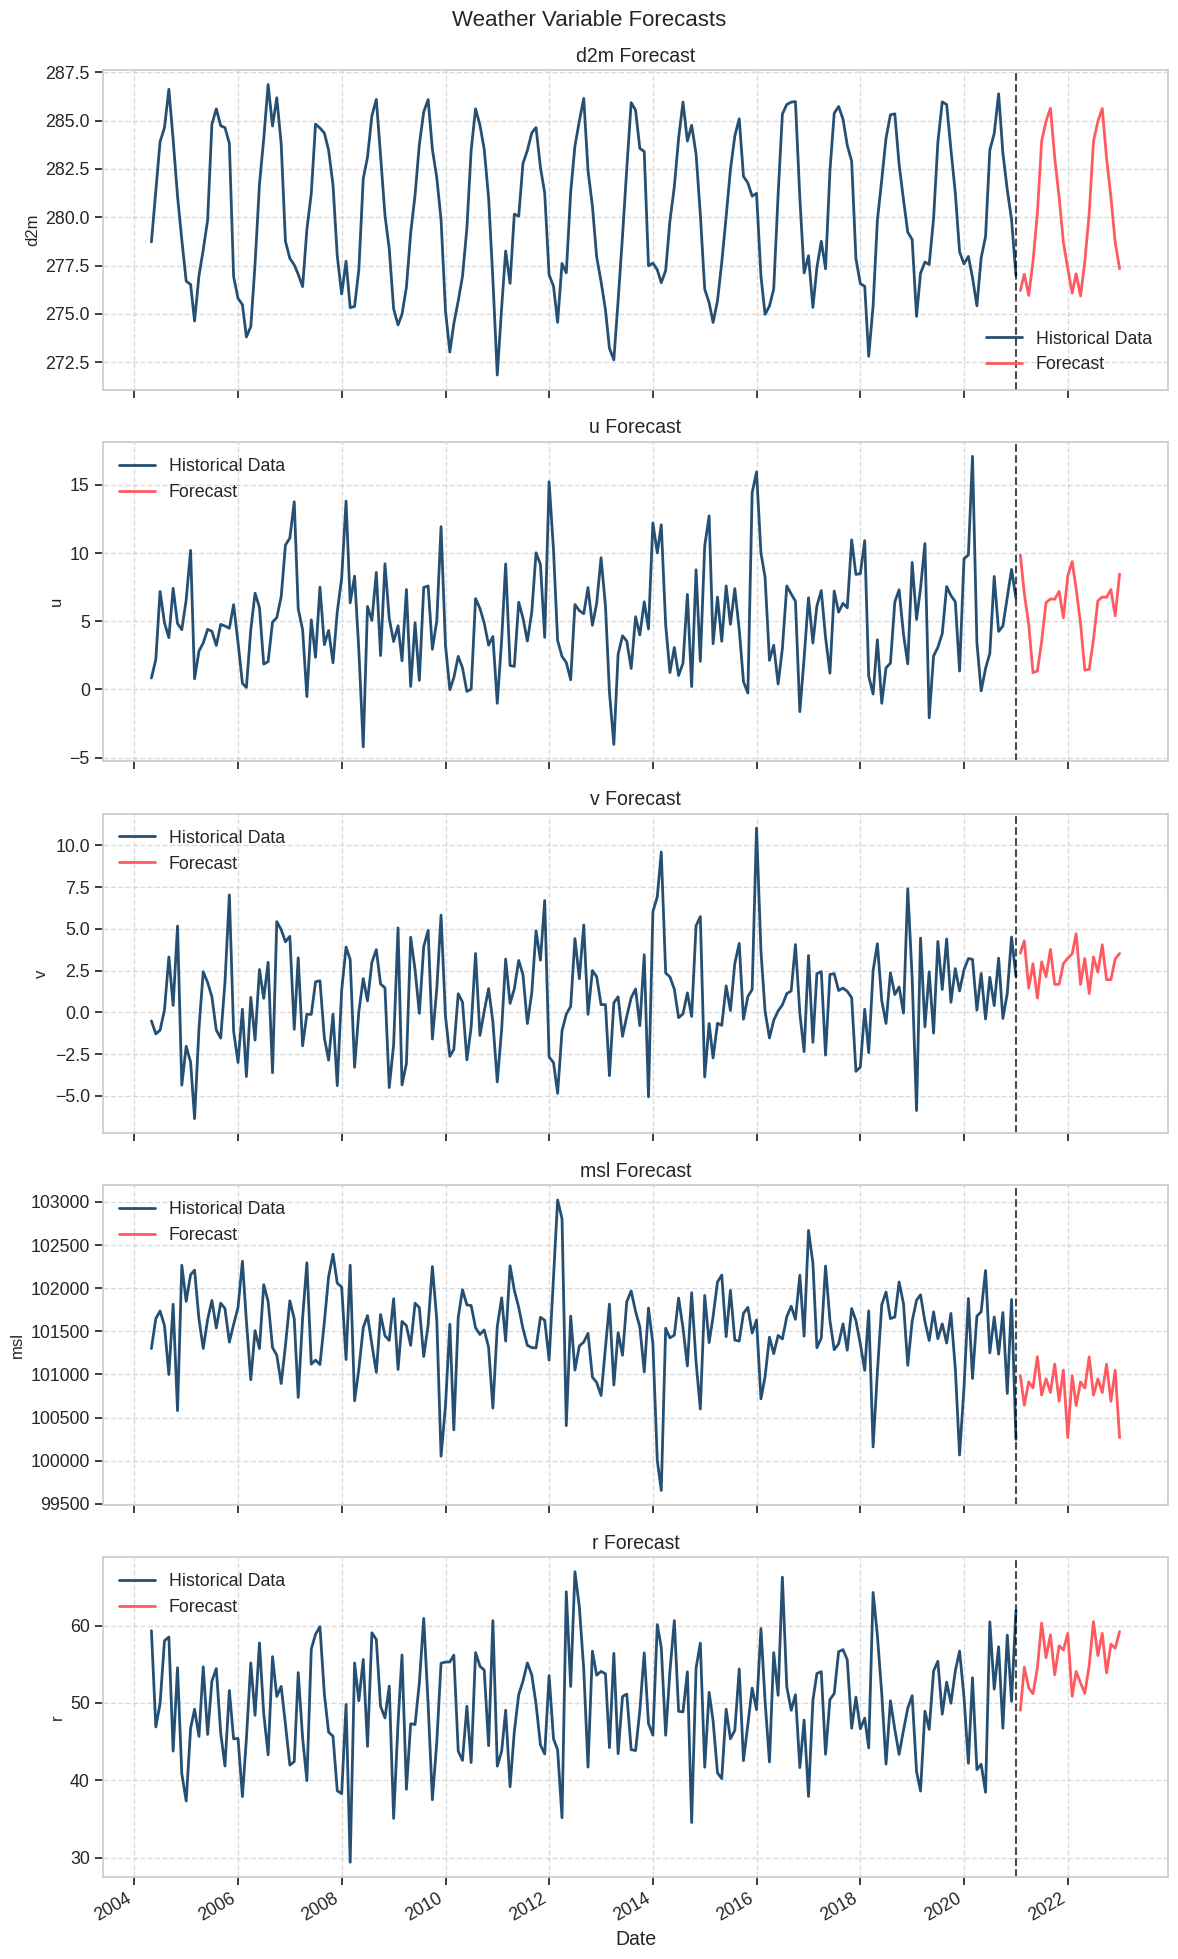

In [18]:
def forecast_multiple_variables(data, variables=None, forecast_periods=24, order=(1, 1, 0)):
    """
    Forecast multiple weather variables and display results
    
    Args:
        data: DataFrame containing time series data
        variables: List of variable names to forecast
        forecast_periods: Number of periods to forecast
        order: ARIMA order tuple (p, d, q)
        
    Returns:
        Figure with all forecasts
    """
    if variables is None:
        variables = variable_list
        
    # Create figure with subplots
    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 1, figsize=(12, 4*n_vars), sharex=True)
    
    # Handle single variable case
    if n_vars == 1:
        axes = [axes]
    
    # Forecast each variable
    for i, var in enumerate(variables):
        # Ensure data has frequency
        ts_data = data[var].copy()
        if ts_data.index.freq is None:
            ts_data.index.freq = data.index.inferred_freq
        
        # Create and fit STL-Forecast model
        stlf = STLForecast(
            ts_data,
            ARIMA,
            seasonal=13,
            period=12,
            robust=True,
            model_kwargs=dict(order=order, trend="t"),
        )
        stlf_result = stlf.fit()
        
        # Generate forecast
        forecast = stlf_result.forecast(forecast_periods)
        
        # Plot historical data
        axes[i].plot(
            ts_data.index, 
            ts_data.values, 
            label='Historical Data',
            color='#265073',
            linewidth=2
        )
        
        # Plot forecast
        axes[i].plot(
            forecast.index, 
            forecast.values, 
            label='Forecast',
            color='#FF5A5F',
            linewidth=2
        )
        
        # Add vertical line separating historical data from forecast
        axes[i].axvline(
            x=ts_data.index[-1], 
            color='black', 
            linestyle='--', 
            alpha=0.7
        )
        
        # Set title and y-label
        axes[i].set_title(f'{var} Forecast', fontsize=14)
        axes[i].set_ylabel(var, fontsize=12)
        
        # Add grid and legend
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].legend(loc='best')
    
    # Set common x-label
    axes[-1].set_xlabel('Date', fontsize=14)
    
    # Format x-axis dates
    fig.autofmt_xdate()
    
    # Add main title
    fig.suptitle('Weather Variable Forecasts', fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    return fig

# Forecast multiple variables
multi_forecast_fig = forecast_multiple_variables(
    data=df_monthly,
    variables=['d2m', 'u', 'v', 'msl', 'r'],
    forecast_periods=24,
    order=(1, 1, 0)
)

## Conclusion and Key Insights

This exploratory data analysis of weather variables has provided several valuable insights:

1. **Wind Pattern Analysis**: 
   - Wind direction shows distinct seasonal patterns
   - Wind components (u and v) display cyclical behavior throughout the year
   - Monthly wind roses reveal clear seasonal shifts in prevailing wind direction

2. **Time Series Decomposition**:
   - All weather variables show strong seasonal components
   - STL decomposition effectively separates trend, seasonal, and residual components
   - Different variables have different seasonal strengths and trend patterns

3. **Sampling and Resampling Effects**:
   - Higher frequency data (1-hour) preserves more detail but contains more noise
   - Different resampling methods (first vs. mean) affect the quality of time series analysis
   - The choice of sampling frequency impacts the detection of periodic patterns

4. **Long-term Trends**:
   - Some variables show slight but consistent long-term trends
   - Year-to-year variability is significant in all weather variables
   - Monthly distributions reveal strong seasonal patterns across all years

5. **Forecasting Potential**:
   - STL-ARIMA models can effectively forecast future values
   - Different variables have different forecast accuracy and uncertainty
   - Seasonal patterns are well-captured in the forecasting models

These insights provide a foundation for more advanced weather data analysis, including similarity metrics for weather analogues and predictive modeling.